##Adversarial Images 
Student's name: Isabella GUIMARÃES AGUIAR DE FARIA and
                Lucas RIBEIRO MARQUES

## Step One

Implementation of FGSM attack of the tutorial in different dataset (NMIST and FashionNMIST) with different CNN architecture.

### I.I) LeNET + MNIST

In the begging we only performed the tutorial with the LeNET achicteture and the MNIST dataset to learn the FGSM attack.  

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
transform = transforms.ToTensor() # convert data to torch.FloatTensor
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [ ]:
batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):    

    num_train, num_test = len(train_data), len(test_data)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)        
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)   
    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

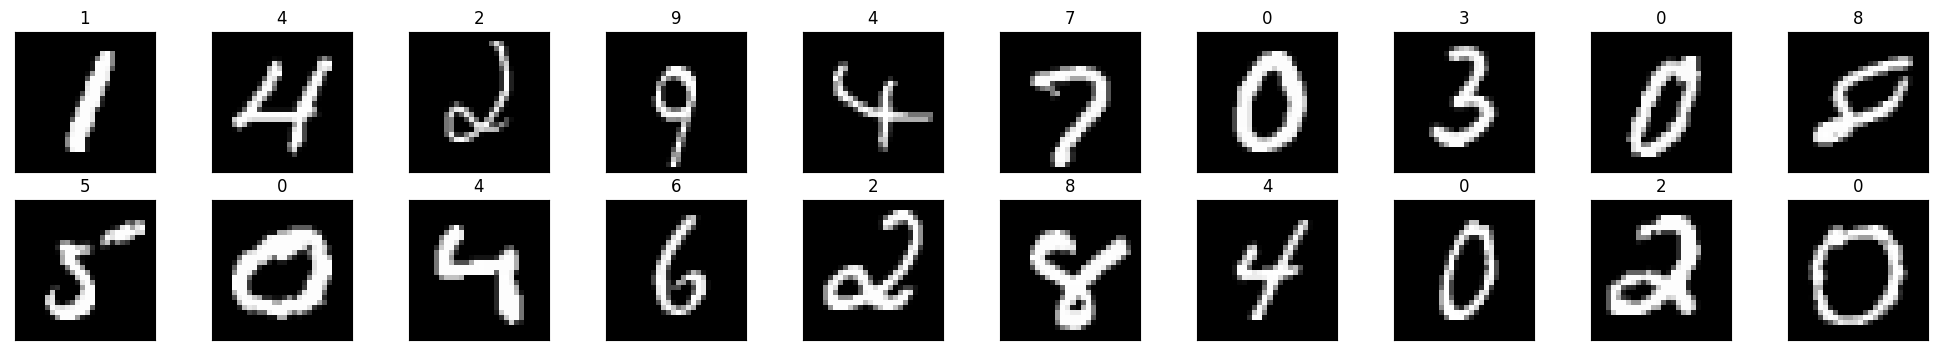

In [ ]:
data_iter = iter(train_loader) 
images, labels = next(data_iter) # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

In [ ]:
class Net1(nn.Module):  
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

print(cnn_1)
summary(cnn_1,(1,28,28))

Net1(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
---

In [ ]:
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

In [ ]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    train_losses, valid_losses = [], []
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity
    
    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0 # monitor losses
        
        # train the model
        model.train() # prep model for training
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(output, label) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item() * data.size(0) # update running training loss
            
            # validate the model
            model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output,label)
            valid_loss += loss.item() * data.size(0)
      
        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
      
        print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'LENET_MNIST.pt')
            valid_loss_min = valid_loss
    
    return train_losses, valid_losses      

In [ ]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

epoch: 1 	training Loss: 0.119759 	validation Loss: 0.105198
validation loss decreased (inf --> 0.105198).  Saving model ...
epoch: 2 	training Loss: 0.091934 	validation Loss: 0.104183
validation loss decreased (0.105198 --> 0.104183).  Saving model ...
epoch: 3 	training Loss: 0.076808 	validation Loss: 0.079696
validation loss decreased (0.104183 --> 0.079696).  Saving model ...
epoch: 4 	training Loss: 0.067035 	validation Loss: 0.069148
validation loss decreased (0.079696 --> 0.069148).  Saving model ...
epoch: 5 	training Loss: 0.058737 	validation Loss: 0.066156
validation loss decreased (0.069148 --> 0.066156).  Saving model ...
epoch: 6 	training Loss: 0.054294 	validation Loss: 0.056319
validation loss decreased (0.066156 --> 0.056319).  Saving model ...
epoch: 7 	training Loss: 0.048717 	validation Loss: 0.057222
epoch: 8 	training Loss: 0.044513 	validation Loss: 0.054353
validation loss decreased (0.056319 --> 0.054353).  Saving model ...
epoch: 9 	training Loss: 0.042137 

In [ ]:
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
pretrained_model = "LENET_MNIST.pt"
use_cuda=True

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# MNIST Train dataset and dataloader declaration

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9865 / 10000 = 0.9865
Epsilon: 0.007	Test Accuracy = 9831 / 10000 = 0.9831
Epsilon: 0.01	Test Accuracy = 9811 / 10000 = 0.9811
Epsilon: 0.02	Test Accuracy = 9734 / 10000 = 0.9734
Epsilon: 0.03	Test Accuracy = 9625 / 10000 = 0.9625
Epsilon: 0.05	Test Accuracy = 9332 / 10000 = 0.9332
Epsilon: 0.1	Test Accuracy = 7597 / 10000 = 0.7597
Epsilon: 0.2	Test Accuracy = 2432 / 10000 = 0.2432
Epsilon: 0.3	Test Accuracy = 814 / 10000 = 0.0814


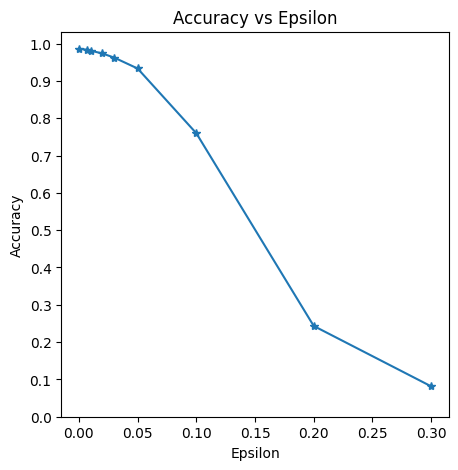

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

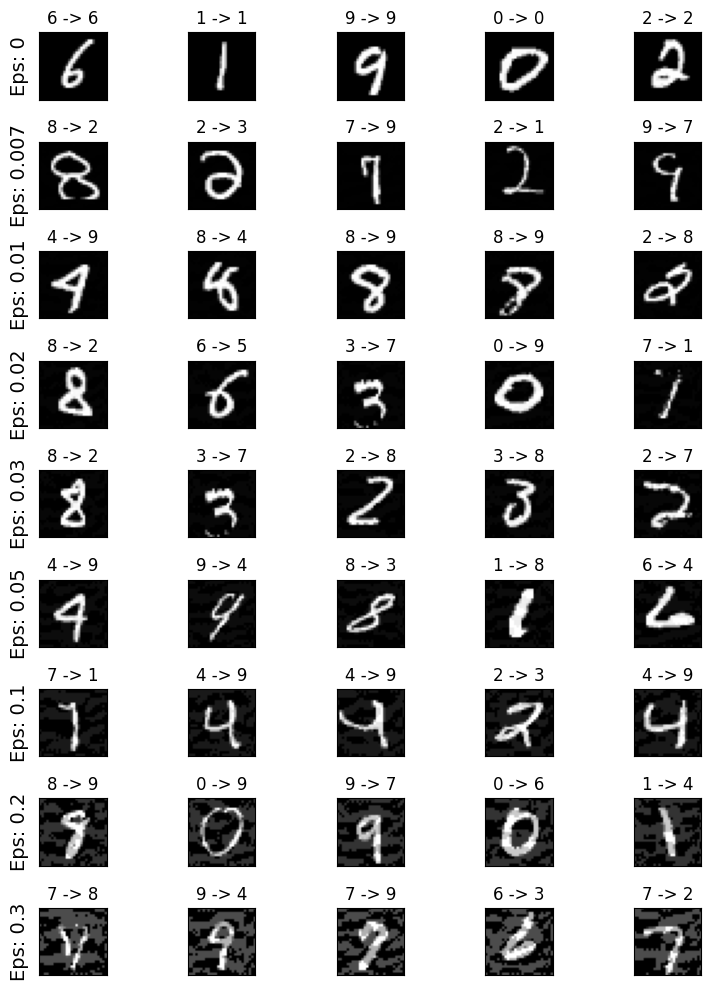

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### I.II) AlexNET + MNIST

We performed the AlexNET achicteture and the MNIST dataset to learn the FGSM attack. 

In [ ]:
transform = transforms.ToTensor() # convert data to torch.FloatTensor
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):    

    num_train, num_test = len(train_data), len(test_data)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)        
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)   
    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

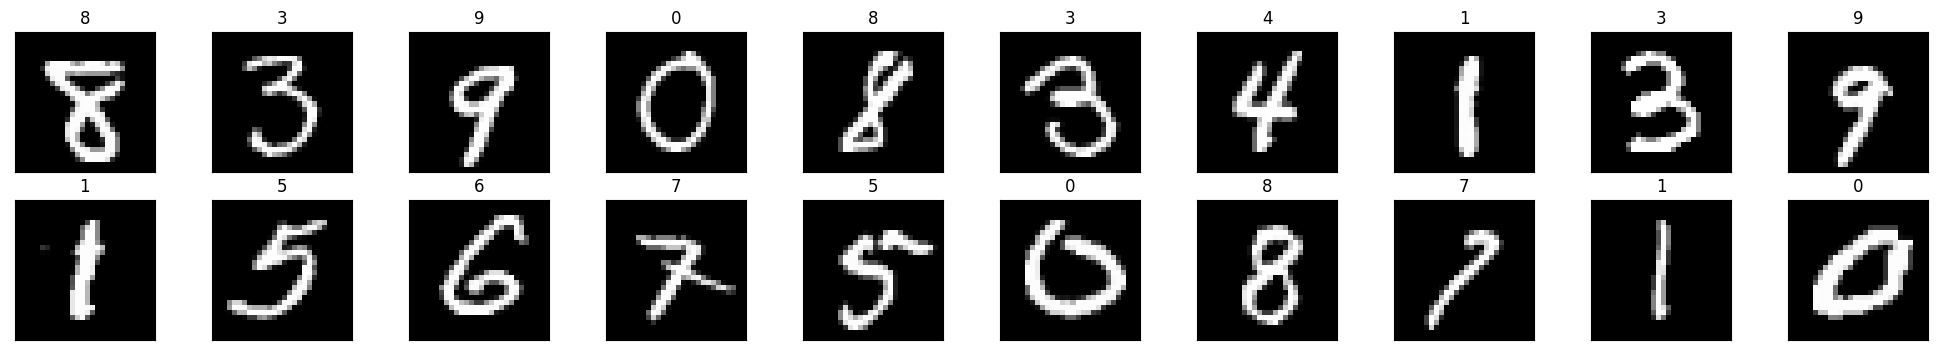

In [ ]:
data_iter = iter(train_loader) 
images, labels = next(data_iter) # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

class Net1(nn.Module):  
    
    def __init__(self):
        super(Net1,self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(14 * 14 * 32, 7 * 7 * 16),
            ReLU(inplace=True),
            Linear(7 * 7 *16, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)   
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
from torchsummary import summary

cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

print(cnn_1)
summary(cnn_1,(1,28,28))

Net1(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=784, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=784, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]  

In [ ]:
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

In [ ]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    train_losses, valid_losses = [], []
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity
    
    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0 # monitor losses
        
        # train the model
        model.train() # prep model for training
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(output, label) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item() * data.size(0) # update running training loss
            
            # validate the model
            model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output,label)
            valid_loss += loss.item() * data.size(0)
      
        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
      
        print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'AlexNET_MNIST.pt')
            valid_loss_min = valid_loss
    
    return train_losses, valid_losses      

In [ ]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

epoch: 1 	training Loss: 0.377468 	validation Loss: 0.187472
validation loss decreased (inf --> 0.187472).  Saving model ...
epoch: 2 	training Loss: 0.135034 	validation Loss: 0.114628
validation loss decreased (0.187472 --> 0.114628).  Saving model ...
epoch: 3 	training Loss: 0.097745 	validation Loss: 0.087485
validation loss decreased (0.114628 --> 0.087485).  Saving model ...
epoch: 4 	training Loss: 0.076979 	validation Loss: 0.082523
validation loss decreased (0.087485 --> 0.082523).  Saving model ...
epoch: 5 	training Loss: 0.061856 	validation Loss: 0.077530
validation loss decreased (0.082523 --> 0.077530).  Saving model ...
epoch: 6 	training Loss: 0.051377 	validation Loss: 0.071324
validation loss decreased (0.077530 --> 0.071324).  Saving model ...
epoch: 7 	training Loss: 0.042002 	validation Loss: 0.064539
validation loss decreased (0.071324 --> 0.064539).  Saving model ...
epoch: 8 	training Loss: 0.033516 	validation Loss: 0.060377
validation loss decreased (0.06453

In [ ]:
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
pretrained_model = "AlexNET_MNIST.pt"
use_cuda=True

In [ ]:
# CNN under attack
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(14 * 14 * 32, 7 * 7 * 16),
            ReLU(inplace=True),
            Linear(7 * 7 *16, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)   
        return x

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=784, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9857 / 10000 = 0.9857
Epsilon: 0.007	Test Accuracy = 9837 / 10000 = 0.9837
Epsilon: 0.01	Test Accuracy = 9827 / 10000 = 0.9827
Epsilon: 0.02	Test Accuracy = 9796 / 10000 = 0.9796
Epsilon: 0.03	Test Accuracy = 9761 / 10000 = 0.9761
Epsilon: 0.05	Test Accuracy = 9670 / 10000 = 0.967
Epsilon: 0.1	Test Accuracy = 9191 / 10000 = 0.9191
Epsilon: 0.2	Test Accuracy = 5118 / 10000 = 0.5118
Epsilon: 0.3	Test Accuracy = 677 / 10000 = 0.0677


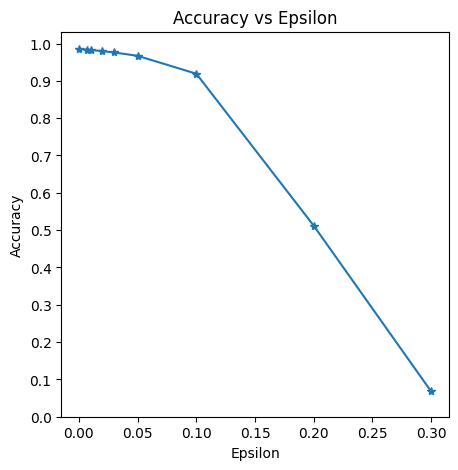

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

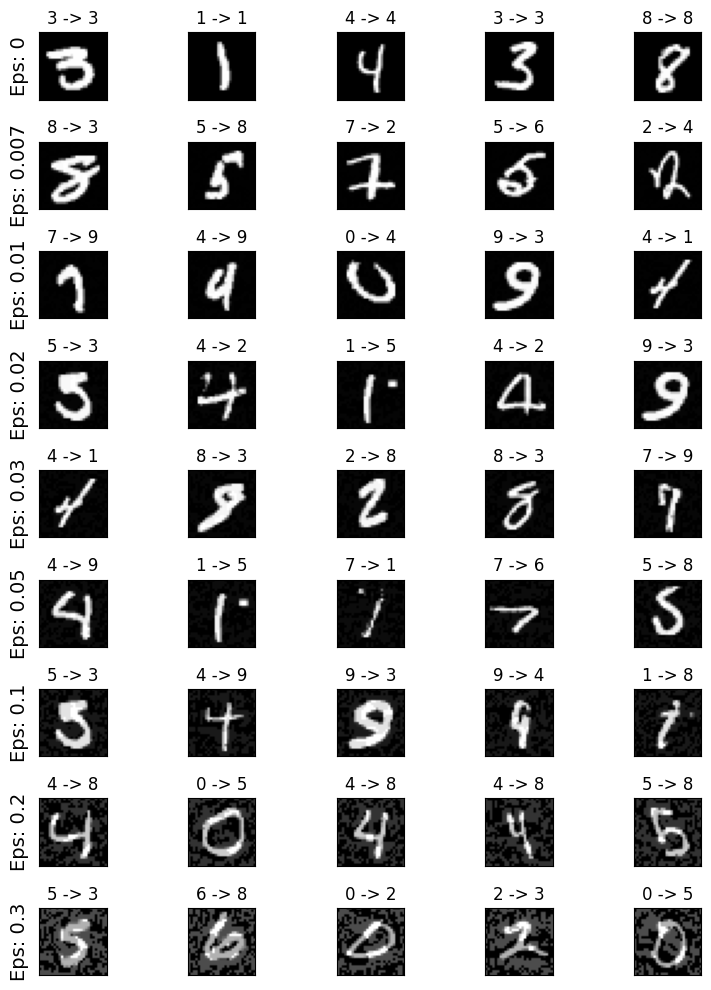

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### I.III) LeNET + FashionMNIST

We performed the LeNET achicteture and the FashionMNIST dataset to learn the FGSM attack. 

In [ ]:
transform = transforms.ToTensor() # convert data to torch.FloatTensor
train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):    

    num_train, num_test = len(train_data), len(test_data)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)        
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)   
    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

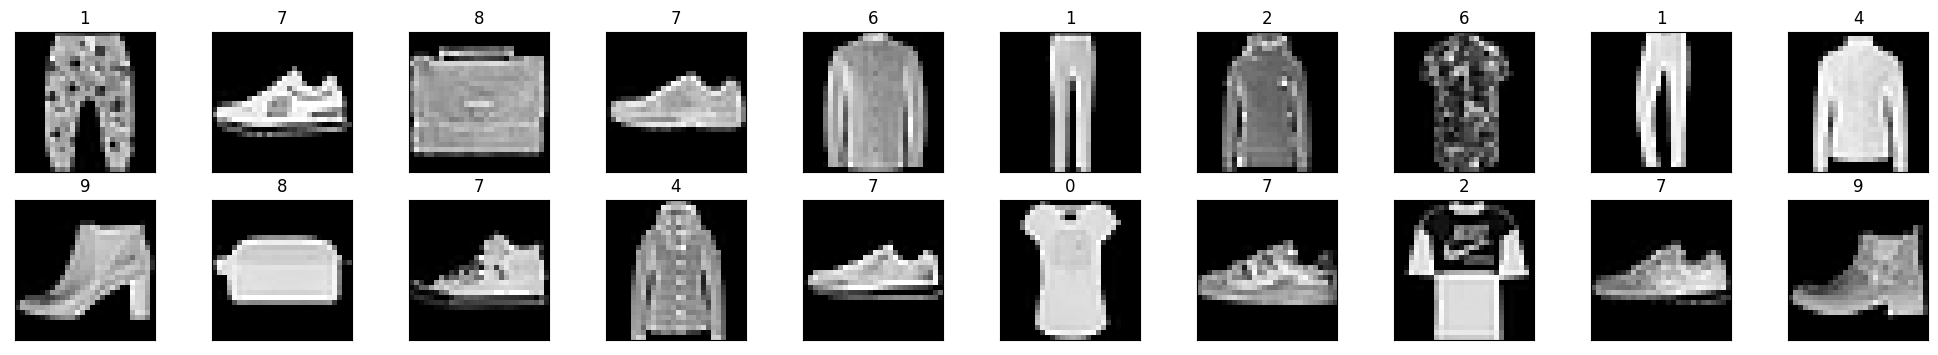

In [ ]:
data_iter = iter(train_loader) 
images, labels = next(data_iter) # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

In [ ]:
class Net1(nn.Module):  
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

print(cnn_1)
summary(cnn_1,(1,28,28))

Net1(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
---

In [ ]:
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

In [ ]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    train_losses, valid_losses = [], []
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity
    
    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0 # monitor losses
        
        # train the model
        model.train() # prep model for training
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(output, label) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item() * data.size(0) # update running training loss
            
            # validate the model
            model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output,label)
            valid_loss += loss.item() * data.size(0)
      
        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
      
        print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'LENET_FashionMNIST.pt')
            valid_loss_min = valid_loss
    
    return train_losses, valid_losses      

In [ ]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

epoch: 1 	training Loss: 0.449394 	validation Loss: 0.433822
validation loss decreased (inf --> 0.433822).  Saving model ...
epoch: 2 	training Loss: 0.415556 	validation Loss: 0.393254
validation loss decreased (0.433822 --> 0.393254).  Saving model ...
epoch: 3 	training Loss: 0.389228 	validation Loss: 0.379083
validation loss decreased (0.393254 --> 0.379083).  Saving model ...
epoch: 4 	training Loss: 0.371282 	validation Loss: 0.371132
validation loss decreased (0.379083 --> 0.371132).  Saving model ...
epoch: 5 	training Loss: 0.354566 	validation Loss: 0.352028
validation loss decreased (0.371132 --> 0.352028).  Saving model ...
epoch: 6 	training Loss: 0.342326 	validation Loss: 0.337657
validation loss decreased (0.352028 --> 0.337657).  Saving model ...
epoch: 7 	training Loss: 0.332068 	validation Loss: 0.359930
epoch: 8 	training Loss: 0.324314 	validation Loss: 0.335624
validation loss decreased (0.337657 --> 0.335624).  Saving model ...
epoch: 9 	training Loss: 0.314923 

In [ ]:
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
pretrained_model = "LENET_FashionMNIST.pt"
use_cuda=True

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# MNIST Train dataset and dataloader declaration

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8886 / 10000 = 0.8886
Epsilon: 0.007	Test Accuracy = 8306 / 10000 = 0.8306
Epsilon: 0.01	Test Accuracy = 8012 / 10000 = 0.8012
Epsilon: 0.02	Test Accuracy = 6949 / 10000 = 0.6949
Epsilon: 0.03	Test Accuracy = 5915 / 10000 = 0.5915
Epsilon: 0.05	Test Accuracy = 4110 / 10000 = 0.411
Epsilon: 0.1	Test Accuracy = 1778 / 10000 = 0.1778
Epsilon: 0.2	Test Accuracy = 305 / 10000 = 0.0305
Epsilon: 0.3	Test Accuracy = 119 / 10000 = 0.0119


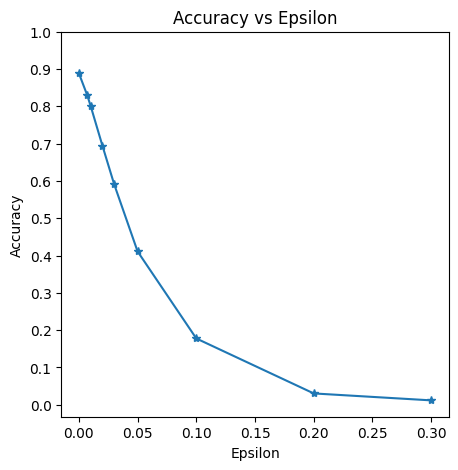

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

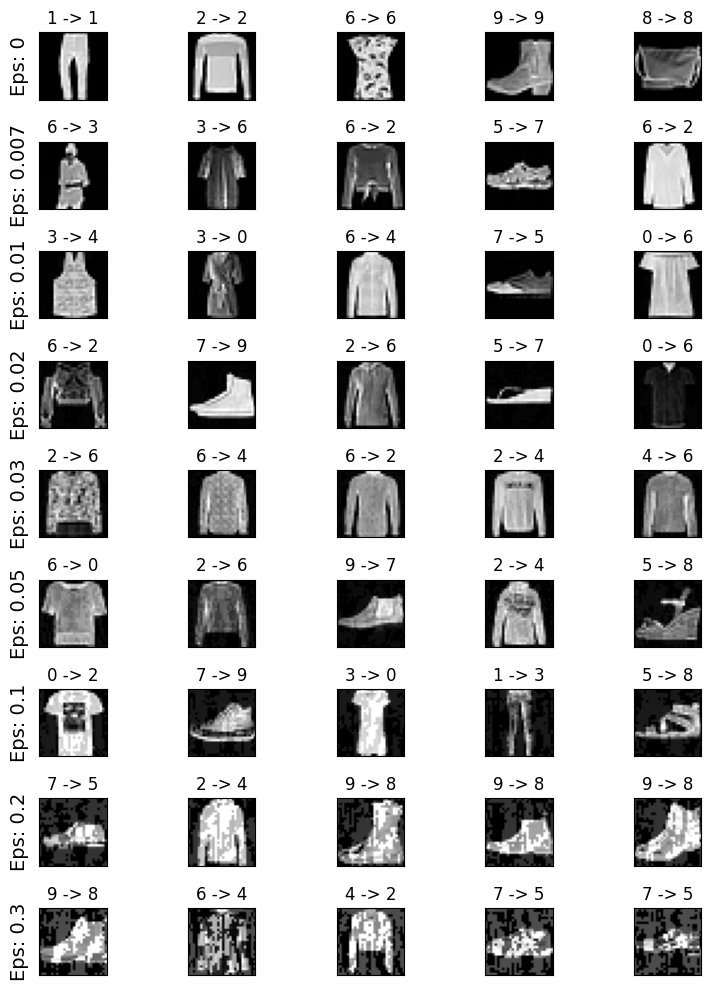

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### I.IV) AlexNET + FashionMNIST

We performed the AlexNET achicteture and the FashionMNIST dataset to learn the FGSM attack. 

In [ ]:
transform = transforms.ToTensor() # convert data to torch.FloatTensor
train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

In [ ]:
batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):    

    num_train, num_test = len(train_data), len(test_data)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)        
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)   
    return train_loader, valid_loader, test_loader

In [ ]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

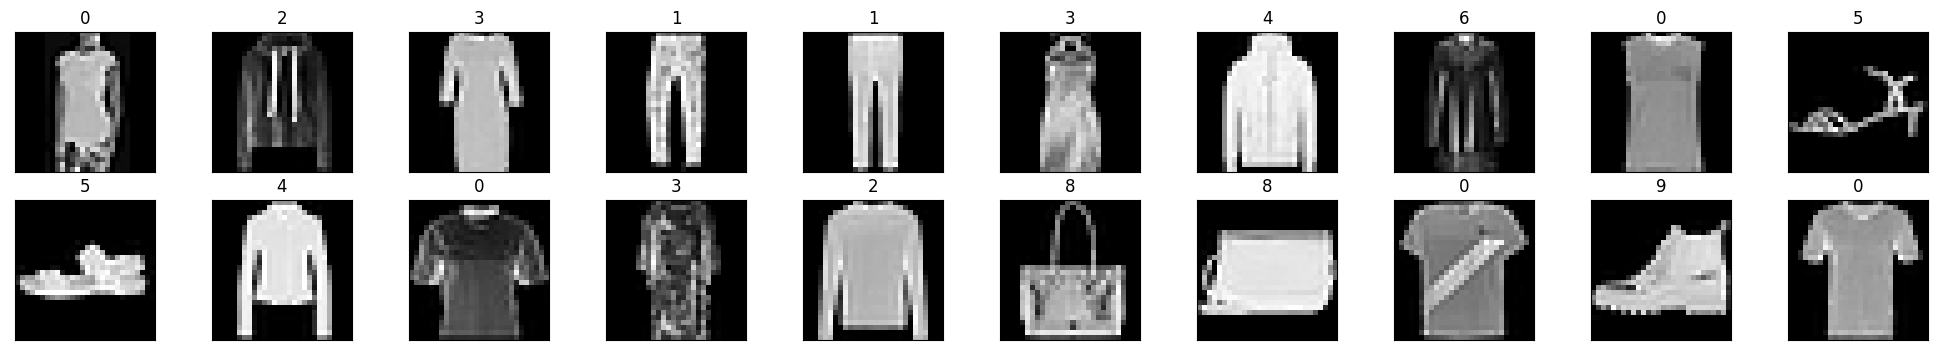

In [ ]:
data_iter = iter(train_loader) 
images, labels = next(data_iter) # obtain one batch from the train set
images = images.numpy()
# plot images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray') # .npsqueeze removes single-dimensional entries from the shape of an array
    ax.set_title(str(labels[idx].item())) # .item() gets the value contained in a Tensor

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

class Net1(nn.Module):  
    
    def __init__(self):
        super(Net1,self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(14 * 14 * 32, 7 * 7 * 16),
            ReLU(inplace=True),
            Linear(7 * 7 *16, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)   
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [ ]:
from torchsummary import summary

cnn_1 = Net1() # initialize the neural network
cnn_1.to(device=device)

print(cnn_1)
summary(cnn_1,(1,28,28))

Net1(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=784, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=784, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]  

In [ ]:
criterion = nn.CrossEntropyLoss() # specify loss function (categorical cross-entropy)
optimizer = torch.optim.SGD(cnn_1.parameters(),lr = 0.01) # specify optimizer (stochastic gradient descent) and learning rate

In [ ]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    train_losses, valid_losses = [], []
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # set initial "min" to infinity
    
    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0 # monitor losses
        
        # train the model
        model.train() # prep model for training
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(output, label) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item() * data.size(0) # update running training loss
            
            # validate the model
            model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output,label)
            valid_loss += loss.item() * data.size(0)
      
        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
      
        print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'AlexNET_FashionMNIST.pt')
            valid_loss_min = valid_loss
    
    return train_losses, valid_losses      

In [ ]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, cnn_1, criterion, optimizer)

epoch: 1 	training Loss: 0.670122 	validation Loss: 0.522985
validation loss decreased (inf --> 0.522985).  Saving model ...
epoch: 2 	training Loss: 0.428355 	validation Loss: 0.417912
validation loss decreased (0.522985 --> 0.417912).  Saving model ...
epoch: 3 	training Loss: 0.355620 	validation Loss: 0.324520
validation loss decreased (0.417912 --> 0.324520).  Saving model ...
epoch: 4 	training Loss: 0.311111 	validation Loss: 0.340665
epoch: 5 	training Loss: 0.279825 	validation Loss: 0.300619
validation loss decreased (0.324520 --> 0.300619).  Saving model ...
epoch: 6 	training Loss: 0.255373 	validation Loss: 0.261560
validation loss decreased (0.300619 --> 0.261560).  Saving model ...
epoch: 7 	training Loss: 0.234885 	validation Loss: 0.247360
validation loss decreased (0.261560 --> 0.247360).  Saving model ...
epoch: 8 	training Loss: 0.216015 	validation Loss: 0.255480
epoch: 9 	training Loss: 0.199461 	validation Loss: 0.254382
epoch: 10 	training Loss: 0.181918 	valida

In [ ]:
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
pretrained_model = "AlexNET_FashionMNIST.pt"
use_cuda=True

In [ ]:
# CNN under attack
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(14 * 14 * 32, 7 * 7 * 16),
            ReLU(inplace=True),
            Linear(7 * 7 *16, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)   
        return x

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=784, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9109 / 10000 = 0.9109
Epsilon: 0.007	Test Accuracy = 8767 / 10000 = 0.8767
Epsilon: 0.01	Test Accuracy = 8603 / 10000 = 0.8603
Epsilon: 0.02	Test Accuracy = 7918 / 10000 = 0.7918
Epsilon: 0.03	Test Accuracy = 7028 / 10000 = 0.7028
Epsilon: 0.05	Test Accuracy = 5171 / 10000 = 0.5171
Epsilon: 0.1	Test Accuracy = 1736 / 10000 = 0.1736
Epsilon: 0.2	Test Accuracy = 24 / 10000 = 0.0024
Epsilon: 0.3	Test Accuracy = 1 / 10000 = 0.0001


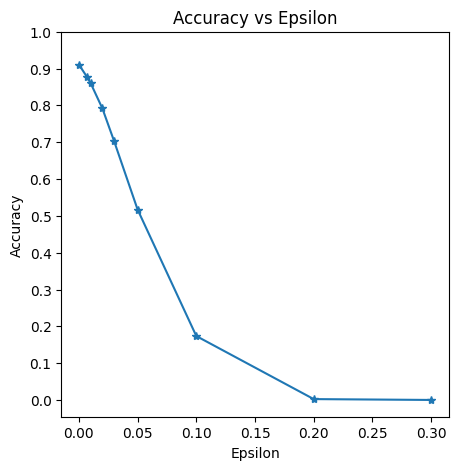

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

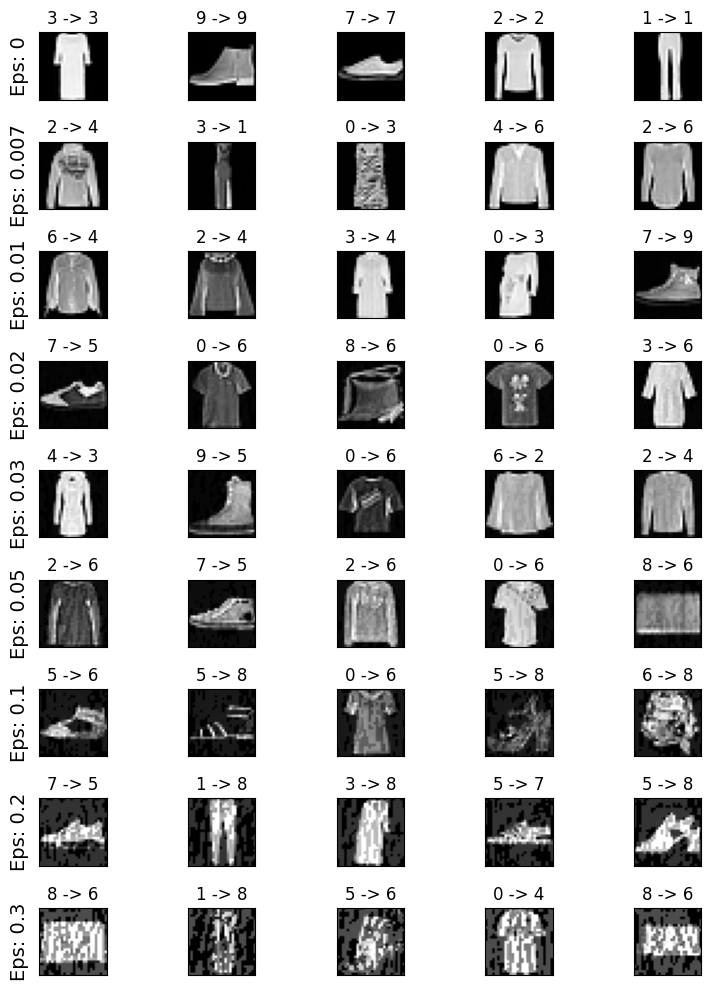

In [ ]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Step Two

Here we performed three types of attacks (FGSM, IFGSM, MFGSM) in a CNN LeNET archicteture. Later, we performed a defense method, destilation. The objective is trying to make the CNN be more robust to this 3 types of attacks. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
#import MNIST
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # convert data to torch.FloatTensor

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

In [ ]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):    

    num_train, num_test = len(train_data), len(test_data)
    # obtain training indices that will be used for validation
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_index, valid_index = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
    val_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)        
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)   
    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

In [ ]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 2400 Validation data: 600 Test data:  500


In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [ ]:
def fit(model,device,train_loader,val_loader,epochs):
    data_loader = {'train':train_loader,'val':val_loader}
    print("Fitting the model...")
    train_loss,val_loss=[],[]
    for epoch in range(epochs):
        loss_per_epoch,val_loss_per_epoch=0,0
        for phase in ('train','val'):
            for i,data in enumerate(data_loader[phase]):
                input,label  = data[0].to(device),data[1].to(device)
                output = model(input)
                #calculating loss on the output
                loss = criterion(output,label)
                if phase == 'train':
                    optimizer.zero_grad()
                    #grad calc w.r.t Loss func
                    loss.backward()
                    #update weights
                    optimizer.step()
                    loss_per_epoch+=loss.item()
                else:
                    val_loss_per_epoch+=loss.item()
        scheduler.step(val_loss_per_epoch/len(val_loader))
        print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
        train_loss.append(loss_per_epoch/len(train_loader))
        val_loss.append(val_loss_per_epoch/len(val_loader))
    return train_loss,val_loss

In [ ]:
loss,val_loss=fit(model,device,train_loader,val_loader,20)

Fitting the model...
Epoch: 1 Loss: 1.1607209682278334 Val_Loss: 0.6172752439479033
Epoch: 2 Loss: 0.531103612271448 Val_Loss: 0.4588725461686651
Epoch: 3 Loss: 0.4205813166142131 Val_Loss: 0.38260126798724137
Epoch: 4 Loss: 0.36557067318198583 Val_Loss: 0.341461536642164
Epoch: 5 Loss: 0.3248508064231525 Val_Loss: 0.318194513587902
Epoch: 6 Loss: 0.30261771465263637 Val_Loss: 0.2910747824423015
Epoch: 7 Loss: 0.2844502018236866 Val_Loss: 0.2699694838188589
Epoch: 8 Loss: 0.2660210036327286 Val_Loss: 0.2610326254647225
Epoch: 9 Loss: 0.2517013112451726 Val_Loss: 0.24689084528634944
Epoch: 10 Loss: 0.24098389294405934 Val_Loss: 0.23514855081215502
Epoch: 11 Loss: 0.22869613405511094 Val_Loss: 0.21790033898005884
Epoch: 12 Loss: 0.22426823777689908 Val_Loss: 0.22344879740926749
Epoch: 13 Loss: 0.21436798685754183 Val_Loss: 0.21470006772161773
Epoch: 14 Loss: 0.20879450752884926 Val_Loss: 0.20159109950220833
Epoch: 15 Loss: 0.19858476462870991 Val_Loss: 0.1973583116553103
Epoch: 16 Loss: 

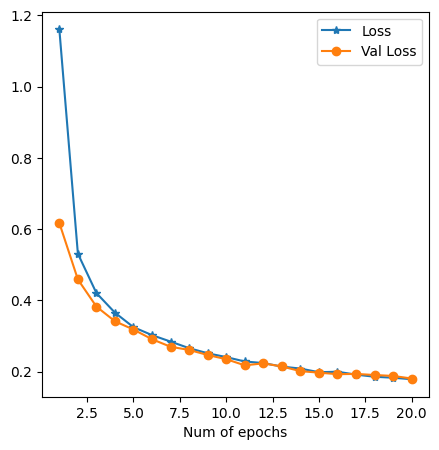

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), loss, "*-",label="Loss")
plt.plot(np.arange(1,21), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [ ]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
#model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
    pert_out = input + epsilon*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    return pert_out

def ifgsm_attack(input,epsilon,data_grad):
    iter = 10
    alpha = epsilon/iter
    pert_out = input
    for i in range(iter-1):
        pert_out = pert_out + alpha*data_grad.sign()
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out-input),p=float('inf')) > epsilon:
            break
    return pert_out

def mifgsm_attack(input,epsilon,data_grad):
    iter=10
    decay_factor=1.0
    pert_out = input
    alpha = epsilon/iter
    g=0
    for i in range(iter-1):
        g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
        pert_out = pert_out + alpha*torch.sign(g)
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out-input),p=float('inf')) > epsilon:
            break
    return pert_out

In [ ]:
def test(model,device,test_loader,epsilon,attack):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        if attack == "fgsm":
            perturbed_data = fgsm_attack(data,epsilon,data_grad)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data,epsilon,data_grad)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data,epsilon,data_grad)
        
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
      
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 913 / 10000 = 0.0913
Epsilon: 0.007	Test Accuracy = 851 / 10000 = 0.0851
Epsilon: 0.01	Test Accuracy = 817 / 10000 = 0.0817
Epsilon: 0.02	Test Accuracy = 701 / 10000 = 0.0701
Epsilon: 0.03	Test Accuracy = 602 / 10000 = 0.0602
Epsilon: 0.05	Test Accuracy = 420 / 10000 = 0.042
Epsilon: 0.1	Test Accuracy = 182 / 10000 = 0.0182
Epsilon: 0.2	Test Accuracy = 50 / 10000 = 0.005
Epsilon: 0.3	Test Accuracy = 34 / 10000 = 0.0034


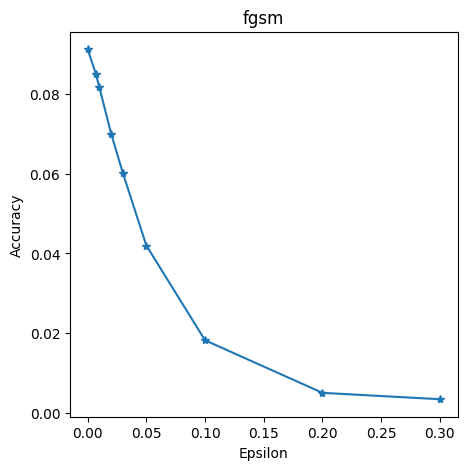

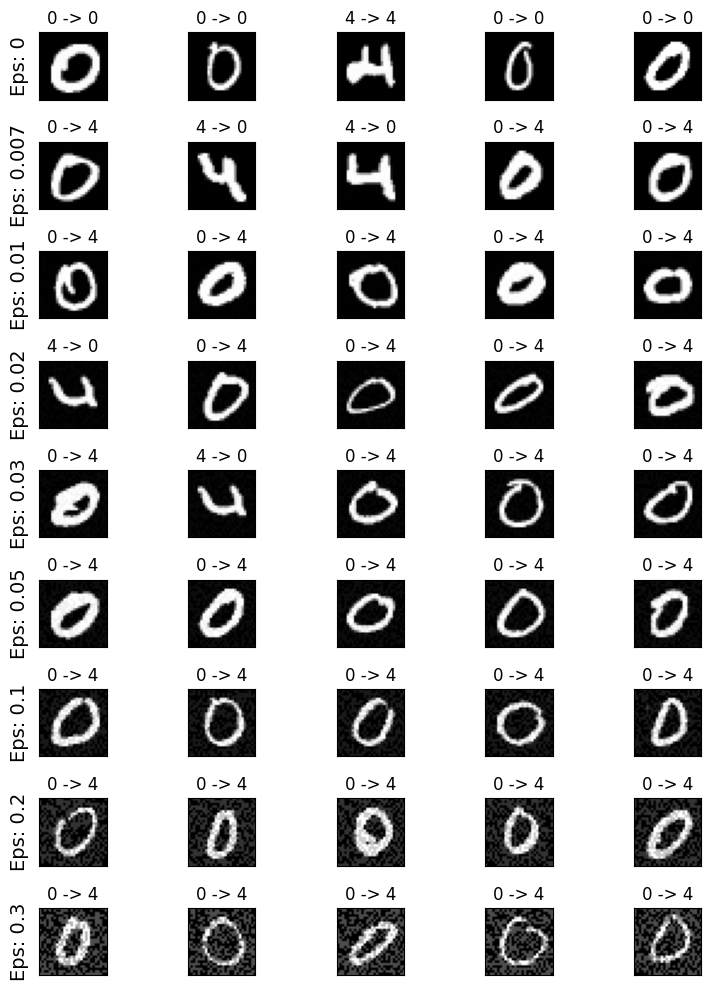

Epsilon: 0	Test Accuracy = 913 / 10000 = 0.0913
Epsilon: 0.007	Test Accuracy = 860 / 10000 = 0.086
Epsilon: 0.01	Test Accuracy = 829 / 10000 = 0.0829
Epsilon: 0.02	Test Accuracy = 731 / 10000 = 0.0731
Epsilon: 0.03	Test Accuracy = 626 / 10000 = 0.0626
Epsilon: 0.05	Test Accuracy = 472 / 10000 = 0.0472
Epsilon: 0.1	Test Accuracy = 214 / 10000 = 0.0214
Epsilon: 0.2	Test Accuracy = 62 / 10000 = 0.0062
Epsilon: 0.3	Test Accuracy = 34 / 10000 = 0.0034


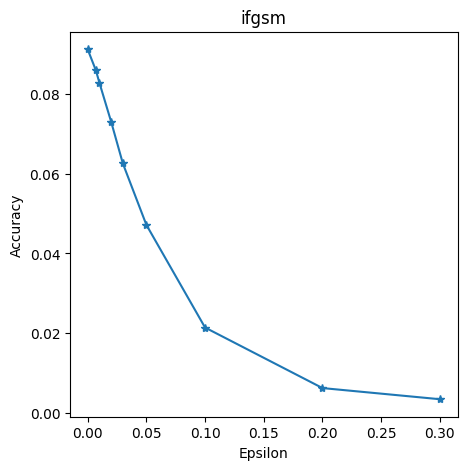

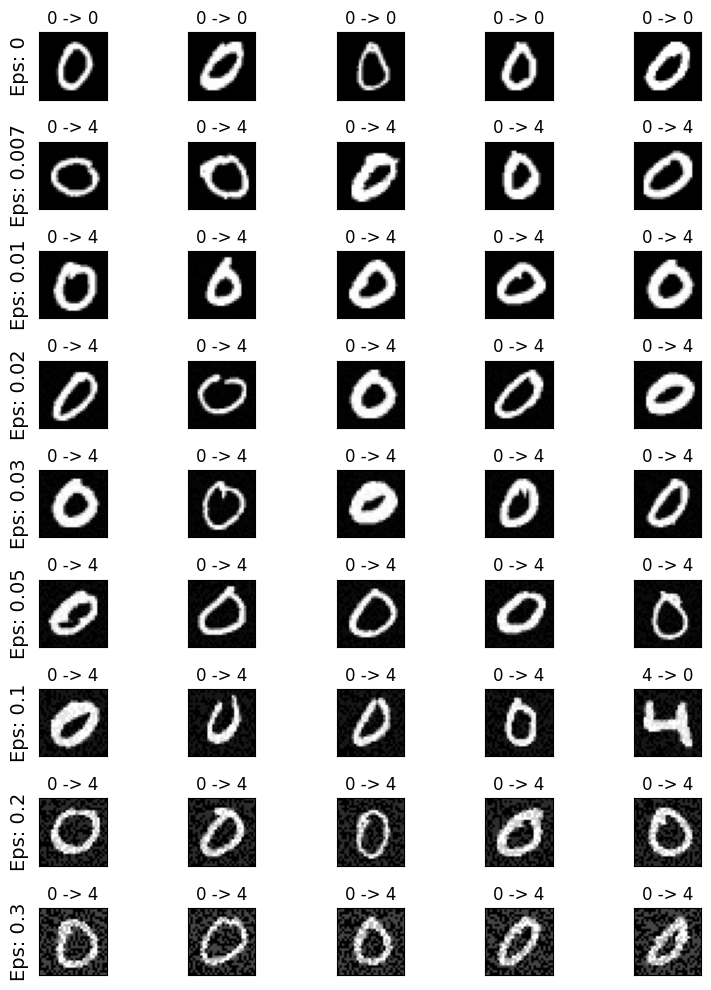

Epsilon: 0	Test Accuracy = 913 / 10000 = 0.0913
Epsilon: 0.007	Test Accuracy = 859 / 10000 = 0.0859
Epsilon: 0.01	Test Accuracy = 829 / 10000 = 0.0829
Epsilon: 0.02	Test Accuracy = 731 / 10000 = 0.0731
Epsilon: 0.03	Test Accuracy = 626 / 10000 = 0.0626
Epsilon: 0.05	Test Accuracy = 471 / 10000 = 0.0471
Epsilon: 0.1	Test Accuracy = 215 / 10000 = 0.0215
Epsilon: 0.2	Test Accuracy = 64 / 10000 = 0.0064
Epsilon: 0.3	Test Accuracy = 32 / 10000 = 0.0032


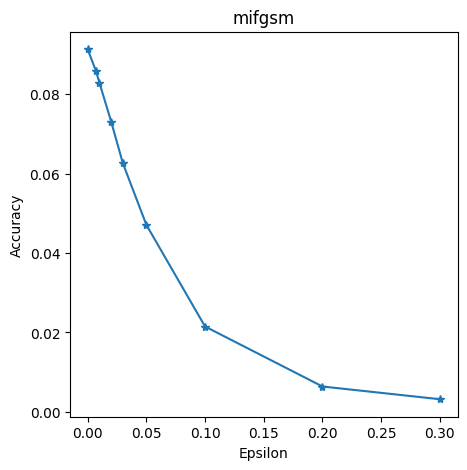

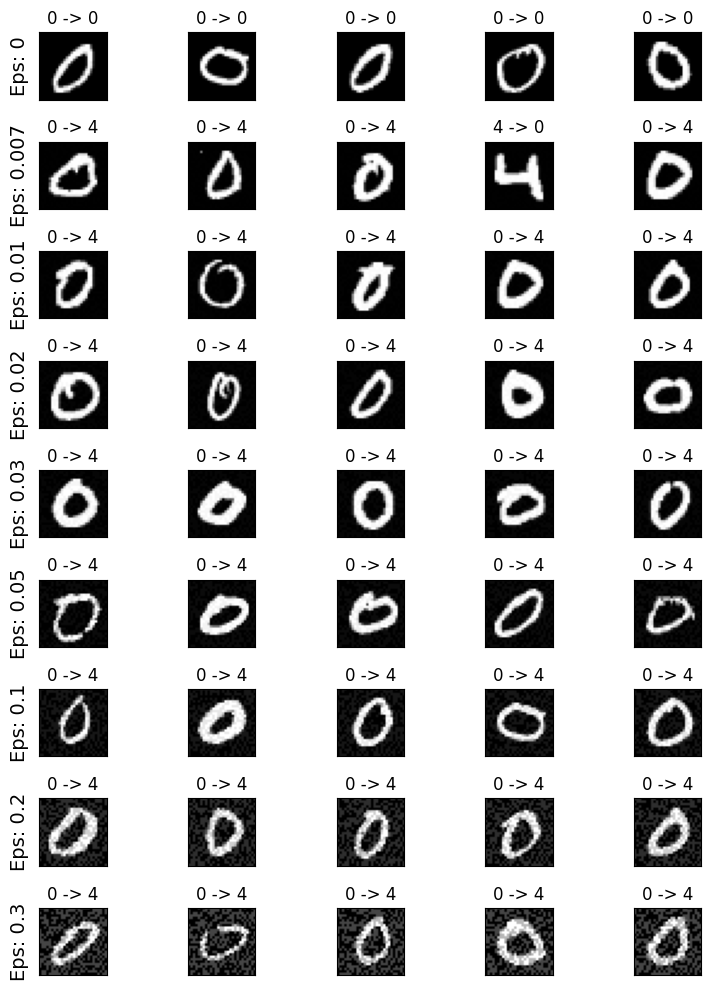

In [ ]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model, device,test_loader,eps,attack)
        accuracies.append(acc)
        examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

##Defense - Destilation method

The objetive of this method is to reduce the effectiveness of adversarial
samples on CNN. Here we use the dataser NMIST with LeNET CNN architecture.

In [ ]:
class NetF(nn.Module):
    def __init__(self):
        super(NetF, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
class NetF1(nn.Module):
    def __init__(self):
        super(NetF1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def fgsm_attack(input,epsilon,data_grad):
    pert_out = input + epsilon*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    return pert_out

def ifgsm_attack(input,epsilon,data_grad):
    iter = 10
    alpha = epsilon/iter
    pert_out = input
    for i in range(iter-1):
        pert_out = pert_out + alpha*data_grad.sign()
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out-input),p=float('inf')) > epsilon:
            break
    return pert_out

def mifgsm_attack(input,epsilon,data_grad):
    iter=10
    decay_factor=1.0
    alpha = epsilon/iter
    pert_out = input
    g=0
    for i in range(iter-1):
        g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
        pert_out = pert_out + alpha*torch.sign(g)
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out-input),p=float('inf')) > epsilon:
            break
    return pert_out

In [ ]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
    data_loader = {'train':train_loader,'val':val_loader}
    print("Fitting the model...")
    train_loss,val_loss=[],[]
    for epoch in range(epochs):
        loss_per_epoch,val_loss_per_epoch=0,0
        for phase in ('train','val'):
            for i,data in enumerate(data_loader[phase]):
                input,label  = data[0].to(device),data[1].to(device)
                output = model(input)
                output = F.log_softmax(output/Temp,dim=1)
                #calculating loss on the output
                loss = criterion(output,label)
                if phase == 'train':
                    optimizer.zero_grad()
                    #grad calc w.r.t Loss func
                    loss.backward()
                    #update weights
                    optimizer.step()
                    loss_per_epoch+=loss.item()
                else:
                    val_loss_per_epoch+=loss.item()
        scheduler.step(val_loss_per_epoch/len(val_loader))
        print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
        train_loss.append(loss_per_epoch/len(train_loader))
        val_loss.append(val_loss_per_epoch/len(val_loader))
    return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        output = F.log_softmax(output/Temp,dim=1)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        if attack == "fgsm":
            perturbed_data = fgsm_attack(data,epsilon,data_grad)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data,epsilon,data_grad)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc,adv_examples

In [ ]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
    modelF = NetF().to(device)
    optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
    schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
    
    modelF1 = NetF1().to(device)
    optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
    schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

    criterion = nn.NLLLoss()
    
    lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
    fig = plt.figure(figsize=(5,5))
    plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
    plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
    plt.title("Network F")
    plt.xlabel("Num of epochs")
    plt.legend()
    plt.show()

    #converting target labels to soft labels
    for data in train_loader:
        input, label  = data[0].to(device),data[1].to(device)
        softlabel  = F.log_softmax(modelF(input),dim=1)
        data[1] = softlabel

    lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
    fig = plt.figure(figsize=(5,5))
    plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
    plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
    plt.title("Network F'")
    plt.xlabel("Num of epochs")
    plt.legend()
    plt.show()

    model = NetF1().to(device)
    model.load_state_dict(modelF1.state_dict())
    for attack in ("fgsm","ifgsm","mifgsm"):
        accuracies = []
        examples = []
        for eps in epsilons:
            acc, ex = test(model,device,test_loader,eps,1,"fgsm")
            accuracies.append(acc)
            examples.append(ex)
    
        plt.figure(figsize=(5,5))
        plt.plot(epsilons, accuracies, "*-")
        plt.title(attack)
        plt.xlabel("Epsilon")
        plt.ylabel("Accuracy")
        plt.show()

        cnt = 0
        plt.figure(figsize=(8,10))
        for i in range(len(epsilons)):
            for j in range(len(examples[i])):
                cnt += 1
                plt.subplot(len(epsilons),len(examples[0]),cnt)
                plt.xticks([], [])
                plt.yticks([], [])
                if j == 0:
                    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
                orig,adv,ex = examples[i][j]
                plt.title("{} -> {}".format(orig, adv))
                plt.imshow(ex, cmap="gray")
        plt.tight_layout()
        plt.show()

Fitting the model...
Epoch: 1 Loss: 1.7262479399393003 Val_Loss: 1.1015152607361476
Epoch: 2 Loss: 0.9469451128194729 Val_Loss: 0.835276077936093
Epoch: 3 Loss: 0.7927962704313298 Val_Loss: 0.7491586260000864
Epoch: 4 Loss: 0.7153833228349685 Val_Loss: 0.6695271933078766
Epoch: 5 Loss: 0.6637889368211229 Val_Loss: 0.6324115964025259
Epoch: 6 Loss: 0.6205057677688698 Val_Loss: 0.5924112456291915
Epoch: 7 Loss: 0.5907429817505181 Val_Loss: 0.5659194405128558
Epoch: 8 Loss: 0.5583346803269038 Val_Loss: 0.5426914851864179
Epoch: 9 Loss: 0.5417350779660046 Val_Loss: 0.5280381708095471
Epoch: 10 Loss: 0.5217725566588343 Val_Loss: 0.5014142474283775
Epoch: 11 Loss: 0.4955160031933337 Val_Loss: 0.4673985607797901
Epoch: 12 Loss: 0.48025537085719405 Val_Loss: 0.4682187374929587
Epoch: 13 Loss: 0.47011587315859893 Val_Loss: 0.462175497636199
Epoch: 14 Loss: 0.4589072315519055 Val_Loss: 0.4492034717525045
Epoch: 15 Loss: 0.4404610244898746 Val_Loss: 0.43318936494489513
Epoch: 16 Loss: 0.430774851

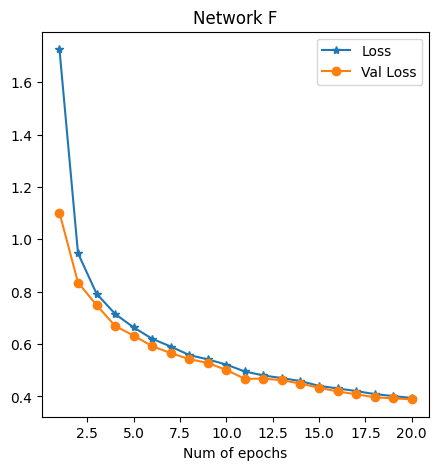

Fitting the model...
Epoch: 1 Loss: 1.6268799352894228 Val_Loss: 1.0131791558365026
Epoch: 2 Loss: 0.8883610929548741 Val_Loss: 0.8013254124919573
Epoch: 3 Loss: 0.7442685795140763 Val_Loss: 0.6977089315156142
Epoch: 4 Loss: 0.668636194417874 Val_Loss: 0.629518471484383
Epoch: 5 Loss: 0.6170227012100319 Val_Loss: 0.5822707231839498
Epoch: 6 Loss: 0.5745281411179651 Val_Loss: 0.5523649369925261
Epoch: 7 Loss: 0.5472761425127586 Val_Loss: 0.5335530112683773
Epoch: 8 Loss: 0.518016365043198 Val_Loss: 0.5004616406063239
Epoch: 9 Loss: 0.49525047558670243 Val_Loss: 0.47291906413932644
Epoch: 10 Loss: 0.4777830249272908 Val_Loss: 0.46978961989283563
Epoch: 11 Loss: 0.4595644364847491 Val_Loss: 0.4386744077069064
Epoch: 12 Loss: 0.45030978912798064 Val_Loss: 0.43898601178079844
Epoch: 13 Loss: 0.43583836662893494 Val_Loss: 0.4251824008176724
Epoch: 14 Loss: 0.4223707567558934 Val_Loss: 0.40677578788250685
Epoch: 15 Loss: 0.4092059651723442 Val_Loss: 0.40066311657428744
Epoch: 16 Loss: 0.39948

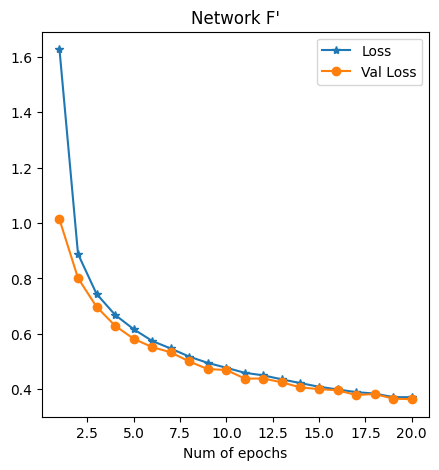

Epsilon: 0	Test Accuracy = 8419 / 10000 = 0.8419
Epsilon: 0.007	Test Accuracy = 8372 / 10000 = 0.8372
Epsilon: 0.01	Test Accuracy = 8457 / 10000 = 0.8457
Epsilon: 0.02	Test Accuracy = 8426 / 10000 = 0.8426
Epsilon: 0.03	Test Accuracy = 8313 / 10000 = 0.8313
Epsilon: 0.05	Test Accuracy = 8302 / 10000 = 0.8302
Epsilon: 0.1	Test Accuracy = 8179 / 10000 = 0.8179
Epsilon: 0.2	Test Accuracy = 8057 / 10000 = 0.8057
Epsilon: 0.3	Test Accuracy = 7908 / 10000 = 0.7908


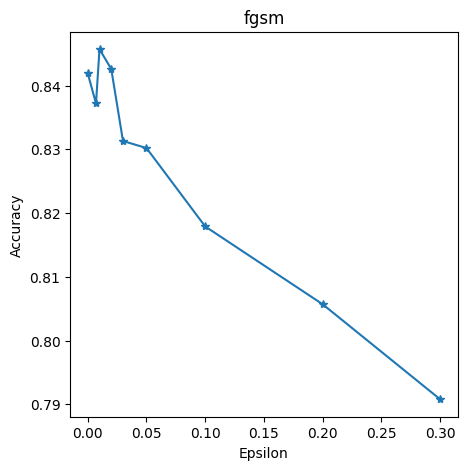

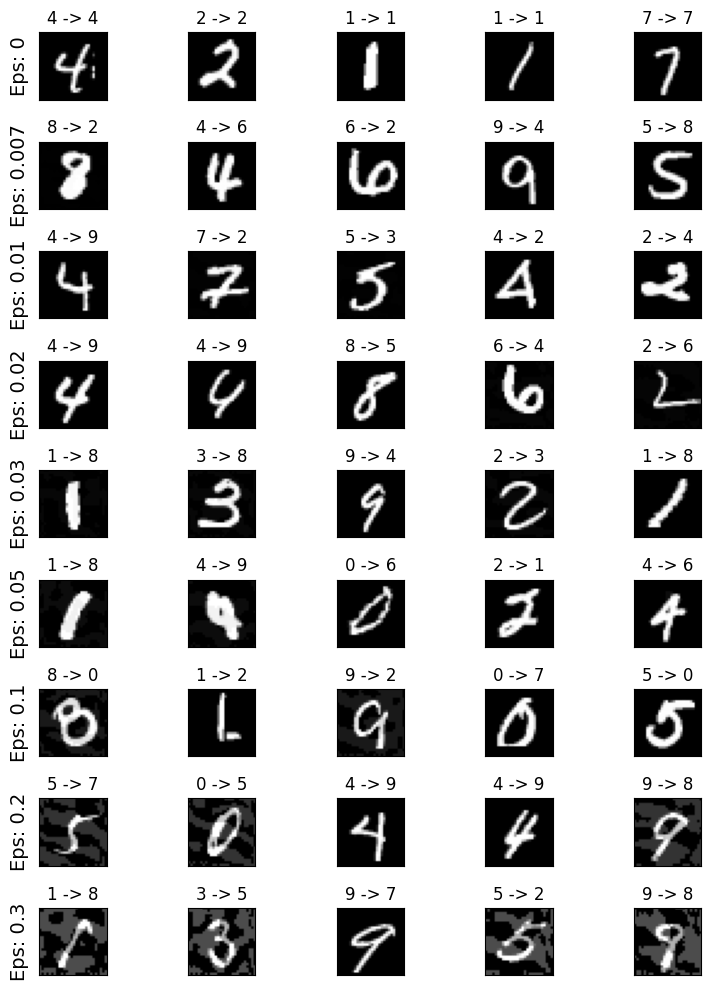

Epsilon: 0	Test Accuracy = 8522 / 10000 = 0.8522
Epsilon: 0.007	Test Accuracy = 8426 / 10000 = 0.8426
Epsilon: 0.01	Test Accuracy = 8488 / 10000 = 0.8488
Epsilon: 0.02	Test Accuracy = 8384 / 10000 = 0.8384
Epsilon: 0.03	Test Accuracy = 8414 / 10000 = 0.8414
Epsilon: 0.05	Test Accuracy = 8346 / 10000 = 0.8346
Epsilon: 0.1	Test Accuracy = 8190 / 10000 = 0.819
Epsilon: 0.2	Test Accuracy = 8064 / 10000 = 0.8064
Epsilon: 0.3	Test Accuracy = 7906 / 10000 = 0.7906


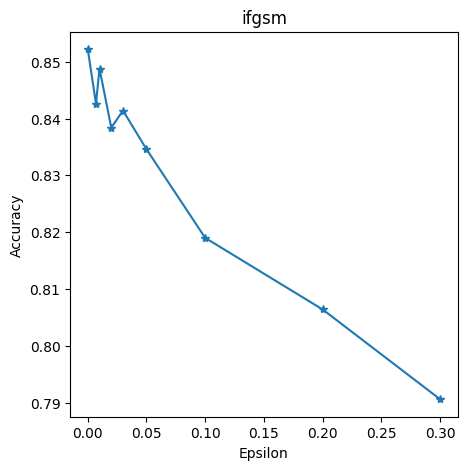

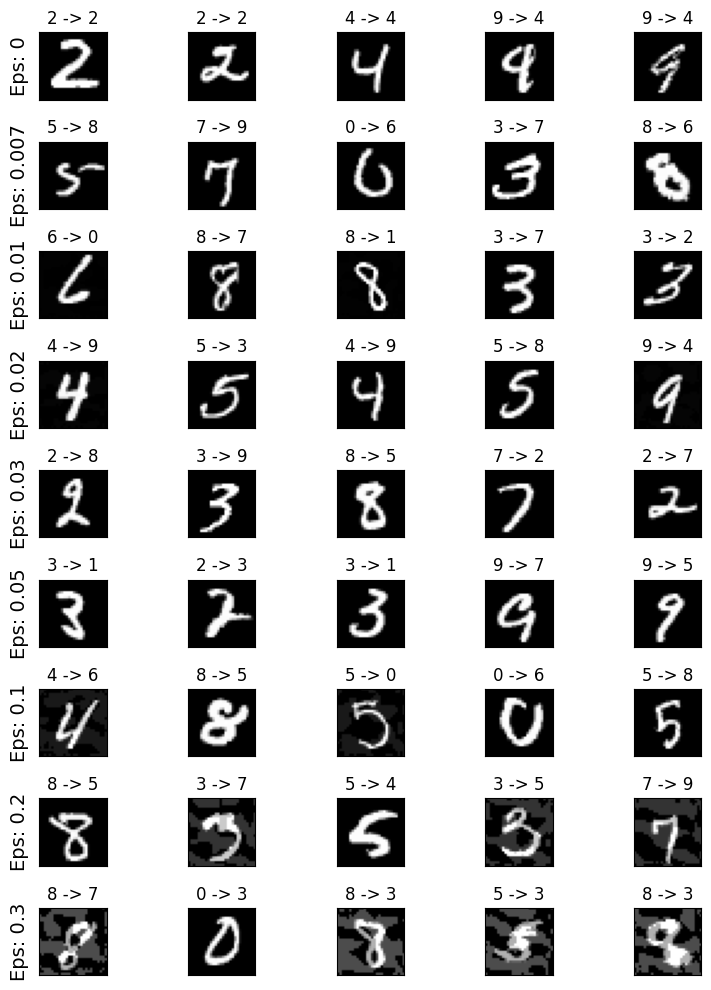

Epsilon: 0	Test Accuracy = 8420 / 10000 = 0.842
Epsilon: 0.007	Test Accuracy = 8438 / 10000 = 0.8438
Epsilon: 0.01	Test Accuracy = 8407 / 10000 = 0.8407
Epsilon: 0.02	Test Accuracy = 8377 / 10000 = 0.8377
Epsilon: 0.03	Test Accuracy = 8392 / 10000 = 0.8392
Epsilon: 0.05	Test Accuracy = 8346 / 10000 = 0.8346
Epsilon: 0.1	Test Accuracy = 8186 / 10000 = 0.8186
Epsilon: 0.2	Test Accuracy = 8007 / 10000 = 0.8007
Epsilon: 0.3	Test Accuracy = 7892 / 10000 = 0.7892


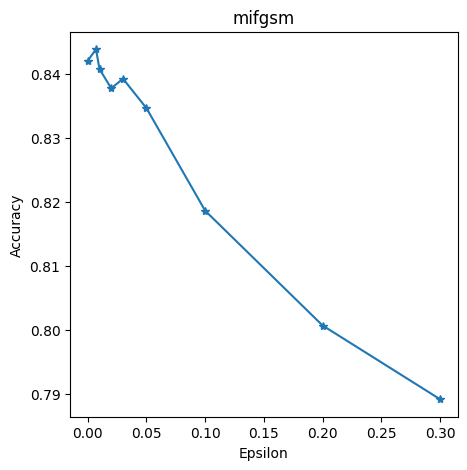

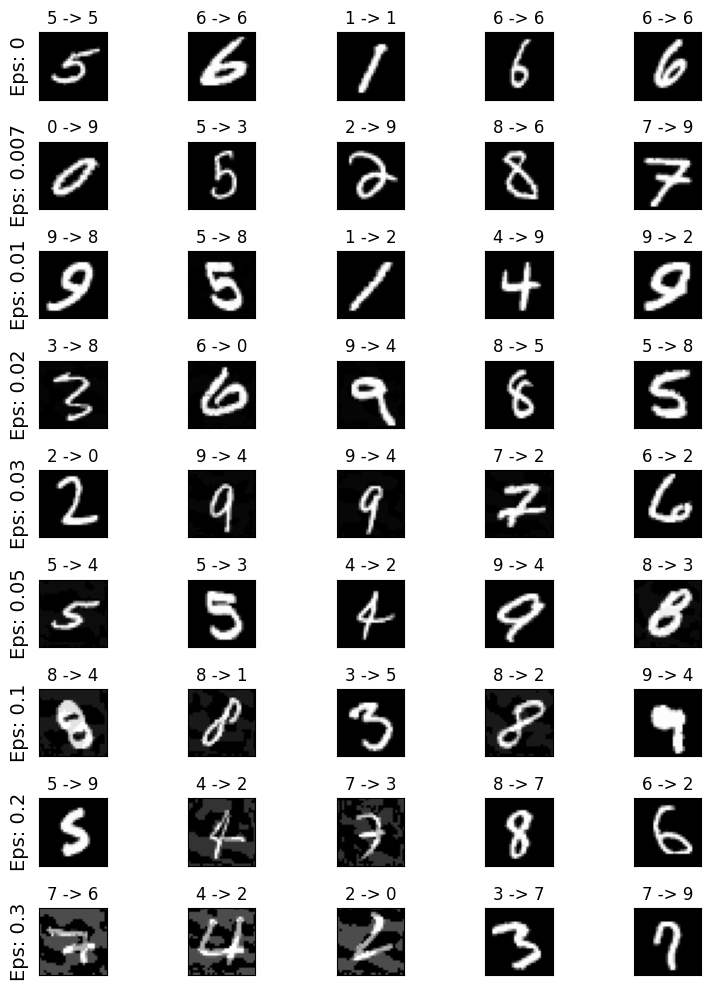

In [ ]:
Temp=100
epochs=20
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)